In [24]:
import os

NUM_THREADS = "1"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np

from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
from yellowbrick.cluster import KElbowVisualizer
scaler = StandardScaler()
min_max_scaler= MinMaxScaler()

sns.set(style="whitegrid")

## FUNCTION

In [25]:
def algo_max(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        labels = pairwise_distances_argmin(X, centers)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)]) 
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

In [26]:
def find_optimal_number_of_cluster(group, k_max):
    scaled_features = scaler.fit_transform(group)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 150,
        "random_state": 42,
    }
    sse = []
    for k in range(1,k_max):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, k_max), sse, curve="convex", direction="decreasing")
    return kl.elbow, sse

In [27]:
def normalize(df):
    normalize = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(normalize, columns=df.columns)
    return df_normalized

In [28]:
X_label = "gdpp"
Y_label = "health"
k_max = 11
df = pd.read_csv('dataset/Country-data.csv')
df_clear = df.drop(columns=["country"]).copy()
df_normalized_example = normalize(df_clear.copy())
group = df_normalized_example[[X_label,Y_label]]
X = np.array(group.values.tolist())

### Пошук оптимальної кількість кластерів

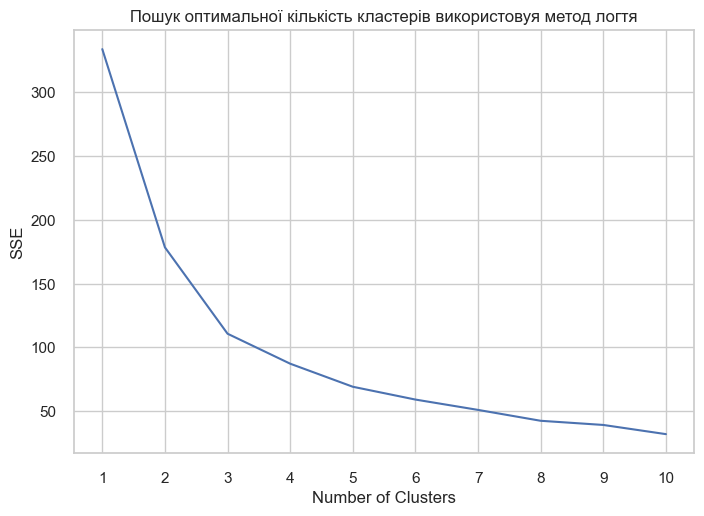

In [29]:
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(group, k_max)
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.title("Пошук оптимальної кількість кластерів використовуя метод логтя")
plt.ylabel("SSE")
plt.show()

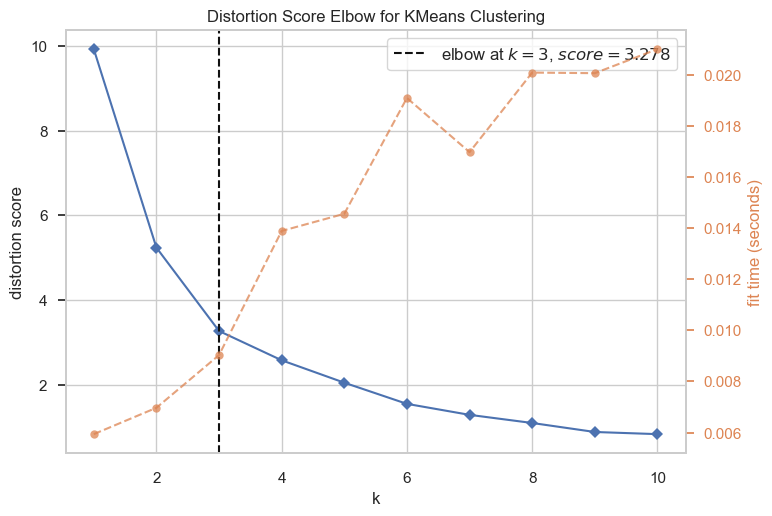

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,k_max))
visualize.fit(group)
visualize.poof()

### Пошук найкращого метода кластерізації для сформованого даного

In [31]:
KMeans_method = cluster.KMeans(init="k-means++", n_clusters=NUMBER_CLUSTER, n_init=10, random_state=24, max_iter=300)
labels_k_mean  = KMeans_method.fit(X).labels_
centers_k_mean = KMeans_method.fit(group).cluster_centers_

centers, labels = algo_max(X, NUMBER_CLUSTER, rseed=0)

SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors', assign_labels='kmeans')
labels_spectral = SpectralClustering_method.fit_predict(X)

dbscan = cluster.DBSCAN(eps=0.25)
scaled_features = scaler.fit_transform(group)
dbscan.fit(scaled_features)
labels_dbscan = dbscan.labels_

df_normalized_example['algo_max'] = labels
df_normalized_example['k-mean'] = labels_k_mean
df_normalized_example['spectral'] = labels_spectral
df_normalized_example['dbscan'] = labels_dbscan

In [32]:
labels_K_Mean = np.insert(np.array(df_normalized_example.loc[:,["k-mean", "imports"]].groupby("k-mean").count().values.tolist()).reshape(-1).astype(str), 0, "K-Mean")
labels_AlgoExp_Max = np.insert(np.array(df_normalized_example.loc[:,["algo_max", "imports"]].groupby("algo_max").count().values.tolist()).reshape(-1).astype(str), 0, "AlgoExp_Max")
labels_Spectral = np.insert(np.array(df_normalized_example.loc[:,["spectral", "imports"]].groupby("spectral").count().values.tolist()).reshape(-1).astype(str), 0, "Spectral")
labels_Dbscan = np.insert(np.array(df_normalized_example.loc[:,["dbscan", "imports"]].groupby("dbscan").count().values.tolist()).reshape(-1).astype(str), 0, "Dbscan")

Text(0.5, 0.98, 'Порівняння різних методів класифікації X: gdpp Y: health')

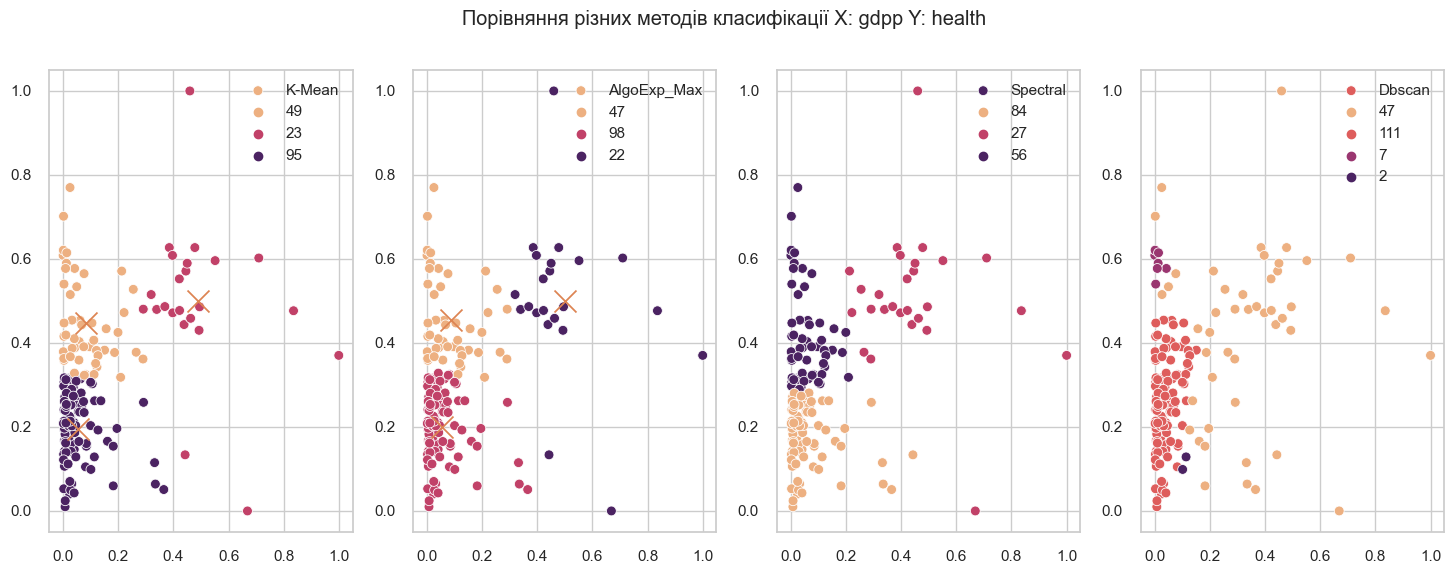

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6))


sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="k-mean", s=50,alpha=1, palette="flare", ax=axes[0])
sns.scatterplot(x=centers_k_mean[:, 0], y=centers_k_mean[:, 1], s=250, zorder=2, marker="x", ax=axes[0], legend=None)
axes[0].legend(labels=labels_K_Mean)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="algo_max", s=50,alpha=1, palette="flare", ax=axes[1])
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=250, zorder=2, marker="x", ax=axes[1], legend=None)
axes[1].legend(labels=labels_AlgoExp_Max)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="spectral", s=50,alpha=1, palette="flare", ax=axes[2])
axes[2].legend(labels=labels_Spectral)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="dbscan", s=50,alpha=1, palette="flare", ax=axes[3])
axes[3].legend(labels=labels_Dbscan)

for ax in axes:
    ax.set(xlabel=None, ylabel=None)
fig.suptitle("Порівняння різних методів класифікації X: {} Y: {}".format(X_label, Y_label))

### Висновок перевірки роботи різних методоів
Найкращим методом для цього кадру даних є K-Mean, Exp Max.
Метод Найгіршим методом для цього набору даних є Dbscan, на основі щільності точок він визначає їх в один кластер, інші значення більше не кластеризуються та відокремлюють їх від шуму.

### Початок роботи

In [34]:
df = pd.read_csv('dataset/Country-data.csv')
df_clear = df.drop(columns = ['country']).copy()

### Нормалізація

In [35]:
df_normalized = normalize(df_clear)

### Кластерізація

In [36]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(df_normalized)

df['cluster'] = model.labels_
df.cluster.value_counts()

2    88
3    46
1    30
0     3
Name: cluster, dtype: int64

In [37]:
clusters = df.groupby(['cluster']).mean()
clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667
1,4.953333,45.826667,9.168667,39.736667,45250.000000,2.742200,80.376667,1.795333,43333.333333
2,22.034091,41.081693,6.263750,47.464385,13088.522727,7.425352,72.671591,2.274545,6980.704545
3,93.284783,29.287174,6.338478,43.297826,3516.804348,12.097065,59.393478,5.090217,1695.913043


In [38]:
df_first_help_result = df[["country","gdpp"]][df.cluster==3].sort_values(['gdpp']).reset_index(drop=True)
df_first_help_result.to_csv('first_help.csv', encoding='utf-8', index=False)
df_first_help_result.head(10)

,country,gdpp
0,Burundi,231
1,Liberia,327
2,"Congo, Dem. Rep.",334
3,Niger,348
4,Sierra Leone,399
5,Madagascar,413
6,Mozambique,419
7,Central African Republic,446
8,Malawi,459
9,Eritrea,482


In [39]:
df_second_help_result = df[["country","gdpp"]][df.cluster==2].sort_values(['gdpp']).reset_index(drop=True)
df_second_help_result.to_csv('second_help.csv', encoding='utf-8', index=False)
df_second_help_result.head(10)

,country,gdpp
0,Nepal,592
1,Tajikistan,738
2,Bangladesh,758
3,Cambodia,786
4,Kyrgyz Republic,880
5,Myanmar,988
6,Vietnam,1310
7,India,1350
8,Uzbekistan,1380
9,Moldova,1630
